In [ ]:
import numpy as np
import torch
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


# Process Classification Masks as Prep for Optimization

In [ ]:
def process_mask(path):
  mask_image = Image.open(path).resize((1019,1024))
  mask_array = np.array(mask_image).astype(np.float32)
  plt.imshow(mask_array)

  return mask_array

def compute_land_use_area(mask):
  #class_dict = {0: 'No data', 1: 'Background', 2: 'Building', 3: 'Road', 4: 'Water', 5: 'Barren', 6: 'Forest', 7: 'Agriculture'}
  class_dict = {0.0: 'Tree canopy', 1.0: 'Grass/Shrubs', 2.0: 'Bare Soil', 3.0: 'Water', 4.0: 'Buildings', 5.0: 'Roads/Railroads', 6.0: 'Other Paved', 7.0: 'Tall Shrubs', 8.0: 'NA'}
  freq_dict = {}

  mask.resize(mask.shape[0]*mask.shape[1])
  classes = Counter(mask)
  for cl in classes.keys():
    freq_dict[class_dict[cl]] = classes[cl] / len(mask)
  
  return freq_dict

In [ ]:
def prepare_for_optimization(land_use_dict, tile_sqft, high_density, med_density):
  # Convert percentages to area in square feet
  land_use_sqft = land_use_dict.copy()
  for key in land_use_sqft:
    land_use_sqft[key] *= tile_sqft

  # Extract the land uses needed for optimization
  cool_roof_area = land_use_sqft['Buildings']
  cool_pave_area = land_use_sqft['Roads/Railroads']
  tree_plant_area = int((land_use_sqft['Grass/Shrubs'] + land_use_sqft['Bare Soil'])/4225) # A Norway Maple (common in Pittsburgh) requires 65 feet spacing, 65 * 65 = 4225
                                                                                            # https://intrans.iastate.edu/app/uploads/sites/15/2018/09/Chapter_10-2017.pdf
  land_uses_for_optimization = [cool_roof_area, cool_roof_area, cool_roof_area, cool_pave_area, tree_plant_area]

  # Reassign list values
  ## If roofs (buildings) make up more than 25% of the image, they are classified as high density 
  ## and there should be zero sq. ft of medium or low density roof
  ## Apply same idea for medium and low density cutoffs

  if land_use_sqft['Buildings'] >= high_density:
    land_uses_for_optimization[1] = 0.0
    land_uses_for_optimization[2] = 0.0
  elif land_use_sqft['Buildings'] >= med_density and land_use_sqft['Buildings'] < high_density:
    land_uses_for_optimization[0] = 0.0
    land_uses_for_optimization[2] = 0.0
  else: 
    land_uses_for_optimization[0] = 0.0
    land_uses_for_optimization[1] = 0.0

  ## If the amount of pavement is less than 4500 sq ft, it is considered insufficient to produce a noticeable cooling effect
  ## These values will also be converted to zero

  if land_uses_for_optimization[3] < 4500:
    land_uses_for_optimization[3] = 0.0

  return land_uses_for_optimization

In [ ]:
def create_allowed_to_install(land_use_opt):
  allowed_to_install = []

  for i in land_use_opt:
    if i > 0.0:
      allowed_to_install.append(1)
    else:
      allowed_to_install.append(0)

  return allowed_to_install

/content/drive/.shortcut-targets-by-id/18epIwhPNr9M-3f7tr7NUA9IDuEiM0DXZ/AI4SG/GIS Classification Outputs
PAALLE024029Or_ClassifyPi.png
PAALLE024029Or_ClassifyPi2.png
PAALLE024029Or_ClassifyPi3.png
3Pittsburgh23029PAALLE0230.png
4Pittsburgh23029PAALLE0230.png
5Pittsburgh23029PAALL_1.png
6Pittsburgh23029PAALLE0230.png
7Pittsburgh23029PAALLE0230.png
8Pittsburgh23029PAALLE0230.png
9Pittsburgh23029PAALLE0230.png
1Pittsburgh23030PAALLE0230.png
7Pittsburgh23030PAALL_1.png
1Pittsburgh23029PAALLE0230.png
2Pittsburgh23029PAALLE0230.png
1Pittsburgh24030PAALLE0240.png
PAALLE023030Or_ClassifyPi4.png


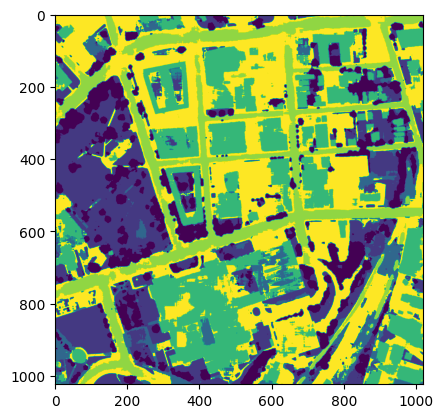

In [ ]:
# Set paramters for prepare_for_optimization
tile_sqft = 3265681.625
high_density = .25 * tile_sqft
med_density = .15 * tile_sqft

# Set current directory to location of the classification masks
%cd '/content/drive/MyDrive/AI4SG/GIS Classification Outputs/'
mask_directory = '/content/drive/MyDrive/AI4SG/GIS Classification Outputs/'

# Iterate through classification masks to process them for optimization
masks = []
allowances = []

for filename in os.listdir(mask_directory):
  print(filename)
  classified_mask = process_mask(filename)
  land_use = compute_land_use_area(classified_mask)
  land_use_for_opt = prepare_for_optimization(land_use, tile_sqft, high_density, med_density)
  allowed_to_install = create_allowed_to_install(land_use_for_opt)

  masks.append(land_use_for_opt)
  allowances.append(allowed_to_install)

# Optimize for Maximum Average Cooling Effect

In [ ]:
!pip install gurobipy
from gurobipy import *
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 80.5 MB/s eta 0:00:00


In [ ]:
# For j in [Cool Roof - High Density, Cool Roof - Medium Density, Cool Roof - Low Density, Cool Pavement, Tree Planting]
# For n in 1, ... N (where N = number of satellite image tiles)

# PARAMETERS
cooling = [0.8, 0.6, 0.4, 1.9, 2.0] #values are in degrees Celsius
cost = [1.325, 1.325, 1.325, 0.94, 3048] #values are in US Dollars
sqft = np.array(masks)
allowed_to_install = np.array(allowances)
budget = 2000000

j = len(cooling)
n = len(sqft)

intervention_set = range(j)
tile_set = range(n)

# MODEL
m = Model()
x = m.addVars(tile_set, intervention_set, vtype = GRB.BINARY) #x is the decision variable of whether or not to install intervention j in tile n
                                                              #vtype = GRB.BINARY specifies it should be a binary variable (don't need a separate constraint)
m.setObjective(1/n * sum(sum(cooling[j] * x[n,j] * allowed_to_install[n,j] for j in intervention_set) for n in tile_set))
m.modelSense = GRB.MAXIMIZE

# CONSTRAINTS
# Budget Constraint
m.addConstr(sum(sum(cost[j] * sqft[n,j] * x[n,j] for j in intervention_set) for n in tile_set) <= budget)

# OPTIMIZE
m.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 80 columns and 48 nonzeros
Model fingerprint: 0xe93d4531
Variable types: 0 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e+05, 1e+06]
  Objective range  [3e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+06, 2e+06]
Found heuristic solution: objective 0.3875000
Presolve removed 0 rows and 33 columns
Presolve time: 0.00s
Presolved: 1 rows, 47 columns, 47 nonzeros
Variable types: 0 continuous, 47 integer (47 binary)
Found heuristic solution: objective 0.4937500

Root relaxation: objective 9.772409e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

In [ ]:
high_density = [x[n,0].x for n in tile_set]
med_density = [x[n,1].x for n in tile_set]
low_density = [x[n,2].x for n in tile_set]
cool_pavement = [x[n,3].x for n in tile_set]
tree_planting = [x[n,4].x for n in tile_set]

print('Average cooling effect achieved:', round(m.objVal, 2), 'C')
print('Percent of tiles with High-Density Cool Roofs recommended:', sum(high_density)/len(high_density)*100, '%')
print('Percent of tiles with Medium-Density Cool Roofs recommended:', sum(med_density)/len(med_density)*100, '%')
print('Percent of tiles with Low-Density Cool Roofs recommended:', sum(low_density)/len(low_density)*100, '%')
print('Percent of tiles with Cool Pavement recommended:', sum(cool_pavement)/len(cool_pavement)*100, '%')
print('Percent of tiles with Tree Planting recommended:', sum(tree_planting)/len(tree_planting)*100, '%')

Average cooling effect achieved: 0.95 C
Percent of tiles with High-Density Cool Roofs recommended: 0.0 %
Percent of tiles with Medium-Density Cool Roofs recommended: 0.0 %
Percent of tiles with Low-Density Cool Roofs recommended: 0.0 %
Percent of tiles with Cool Pavement recommended: 50.0 %
Percent of tiles with Tree Planting recommended: 0.0 %


In [ ]:
cool_pavement

[-0.0,
 -0.0,
 -0.0,
 1.0,
 1.0,
 1.0,
 -0.0,
 1.0,
 1.0,
 -0.0,
 -0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 -0.0]

## Test Optimization Under Different Parameters

In [ ]:
def optimize(masks, allowances, budget, cost_array):
# For j in [Cool Roof - High Density, Cool Roof - Medium Density, Cool Roof - Low Density, Cool Pavement, Tree Planting]
# For n in 1, ... N (where N = number of satellite image tiles)

# PARAMETERS
  cooling = [0.8, 0.6, 0.4, 1.9, 2.0] #values are in degrees Celsius
  cost = cost_array #values are in US Dollars
  sqft = np.array(masks)
  allowed_to_install = np.array(allowances)
  budget = budget

  j = len(cooling)
  n = len(sqft)

  intervention_set = range(j)
  tile_set = range(n)

# MODEL
  m = Model()
  x = m.addVars(tile_set, intervention_set, vtype = GRB.BINARY) #x is the decision variable of whether or not to install intervention j in tile n
                                                              #vtype = GRB.BINARY specifies it should be a binary variable (don't need a separate constraint)
  m.setObjective(1/n * sum(sum(cooling[j] * x[n,j] * allowed_to_install[n,j] for j in intervention_set) for n in tile_set))
  m.modelSense = GRB.MAXIMIZE

# CONSTRAINTS
# Budget Constraint
  m.addConstr(sum(sum(cost[j] * sqft[n,j] * x[n,j] for j in intervention_set) for n in tile_set) <= budget)

# OPTIMIZE
  m.optimize()

# Collect outputs
  high_density = [x[n,0].x for n in tile_set]
  med_density = [x[n,1].x for n in tile_set]
  low_density = [x[n,2].x for n in tile_set]
  cool_pavement = [x[n,3].x for n in tile_set]
  tree_planting = [x[n,4].x for n in tile_set]

# Calculate percent of tiles with each intervention
  high_density_pct = sum(high_density)/len(high_density)*100
  med_density_pct = sum(med_density)/len(med_density)*100
  low_density_pct = sum(low_density)/len(low_density)*100
  cool_pave_pct = sum(cool_pavement)/len(cool_pavement)*100
  tree_plant_pct = sum(tree_planting)/len(tree_planting)*100

# Print results
  print('Average cooling effect achieved:', round(m.objVal, 2), 'C')
  print('Percent of tiles with High-Density Cool Roofs recommended:', high_density_pct, '%')
  print('Percent of tiles with Medium-Density Cool Roofs recommended:', med_density_pct, '%')
  print('Percent of tiles with Low-Density Cool Roofs recommended:', low_density_pct, '%')
  print('Percent of tiles with Cool Pavement recommended:', cool_pave_pct, '%')
  print('Percent of tiles with Tree Planting recommended:', tree_plant_pct, '%')

  return [round(m.objVal, 2), high_density_pct, med_density_pct, low_density_pct, cool_pave_pct, tree_plant_pct]

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 80 columns and 48 nonzeros
Model fingerprint: 0x42769f47
Variable types: 0 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [2e+05, 2e+06]
  Objective range  [3e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+06, 1e+06]
Found heuristic solution: objective 0.1437500
Presolve removed 0 rows and 66 columns
Presolve time: 0.00s
Presolved: 1 rows, 14 columns, 14 nonzeros
Found heuristic solution: objective 0.3562500
Variable types: 0 continuous, 14 integer (14 binary)

Root relaxation: objective 4.366951e-01, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

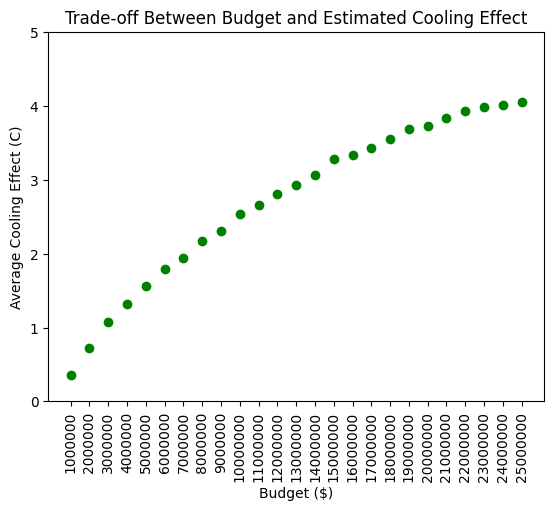

In [ ]:
# Plot efficient frontier of cooling and budget
budgets = list(range(1000000, 26000000, 1000000))

for budget in budgets:
  output = optimize(masks, allowances, budget, cost)
  y = output[0]
  x = budget
  plt.xlabel('Budget ($)')
  plt.ylabel('Average Cooling Effect (C)')
  plt.title('Trade-off Between Budget and Estimated Cooling Effect')
  plt.xticks(budgets, rotation = 90)
  plt.ticklabel_format(style='plain')
  plt.ylim(0,5)
  plt.scatter(x, y, c = 'green')

plt.show()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1 rows, 80 columns and 48 nonzeros
Model fingerprint: 0x8475627a
Variable types: 0 continuous, 80 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e+05, 8e+05]
  Objective range  [3e-02, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+07, 1e+07]
Found heuristic solution: objective 2.8687500
Presolve removed 0 rows and 32 columns
Presolve time: 0.00s
Presolved: 1 rows, 48 columns, 48 nonzeros
Variable types: 0 continuous, 48 integer (48 binary)
Found heuristic solution: objective 3.4375000

Root relaxation: objective 3.627724e+00, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

 

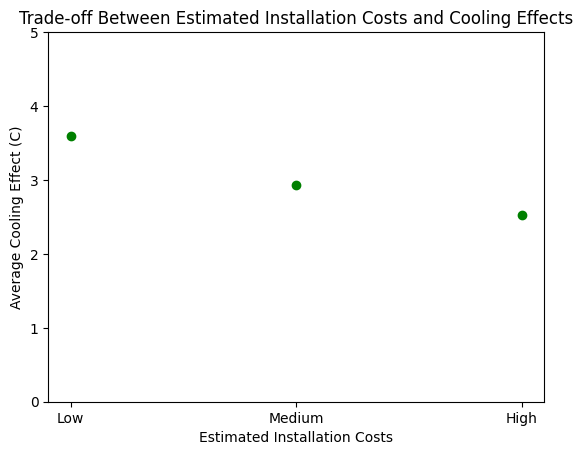

In [ ]:
# Plot efficient frontier of cooling and cost
budget = 10000000
costs = [[0.6, 0.6, 0.6, 0.66, 2159],
        [1.325, 1.325, 1.325, 0.94, 3048],
        [2.05, 2.05, 2.05, 1.22, 3936]]

for cost, level in zip(costs, [1,2,3]):
  output = optimize(masks, allowances, budget, cost)
  y = output[0]
  x = level
  plt.xlabel('Estimated Installation Costs')
  plt.ylabel('Average Cooling Effect (C)')
  plt.title('Trade-off Between Estimated Installation Costs and Cooling Effects')
  plt.xticks([1, 2, 3], ['Low', 'Medium', 'High'])
  plt.ylim(0,5)
  plt.scatter(x, y, c='green')

plt.show()